# ABC PRC Tutorial
In this tutorial we will be constructing our own individual-based model and performing model fitting on the resulting summary statistics it produces.

In [1]:
%matplotlib inline
import ABCPRC as prc
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Define model
We firstly want to define a model to perform the fitting on. We'll take an example from parasitic epidemiology. Intestinal worms (Helminths) are picked up from the environment. Some individuals, due to behaviour and location may be more at risk of being exposed. We'll model this exposure using a gamma-distribution with shape parameter $\gamma$. This together with a constant background rate of infection $\lambda$ defines the rate at which worms are ingested and survive. Density independent death of the worms is also assumed at constant rate $\delta$. We may define the model ibm as

In [10]:
def ibm(*ps):
    lbda,delta,gamma = ps[0],ps[1],ps[2]
    dt = 1.0 #time step
    n = 100 #population number
    T = 100 #total time simulation is run for.
    class Person(object): #define individual
        def __init__(self):
            self.br = stats.gamma.rvs(gamma) if gamma > 0 else 0 #risk of exposure for individual
            self.ps = 0 #number of parasites. This is zero initially.
        def update(self):
            births = stats.poisson.rvs(self.br * lbda * dt) if self.br * lbda * dt > 0 else 0 #imports of new worms in a time-step
            deaths = stats.poisson.rvs(self.ps * delta) if self.ps >0 else 0 #number of deaths of worms
            self.ps += (births-deaths)
            if (self.ps < 0): self.ps = 0 #check number doesn't become negative.
    people = []
    for i in range(n):
       people.append(Person()) #initialise population.
    for t in range(T):
        for i in range(n):
            people[i].update() #run simulation for all individuals.
    par_dist = []
    for i in range(n):
        par_dist.append(people[i].ps) #record final number of parasites for each individual.
    return np.array(par_dist) # ibm function needs to return a numpy array

Let's run the model and plot the results for some values.
We'll take the transmission potential as 10.0, the shape of transmission as 1.0 and the density-independent death rate as 0.5

CPU times: user 901 ms, sys: 33.8 ms, total: 934 ms
Wall time: 910 ms


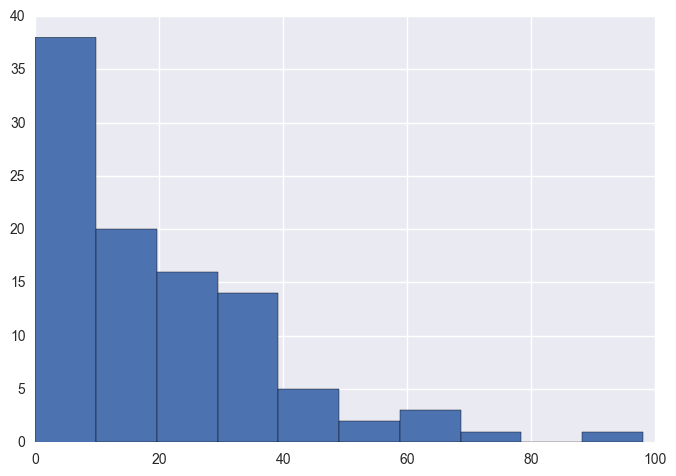

In [16]:
%time xs = ibm(10.0,0.5,1.0)
plt.hist(xs);

## Setting up the model fitting
The main module class is ABC. This can be initilaized without any arguments. The various aspects of ABC can then be setup using the ```setup()``` method. key-word arguments ```modelFunc``` defines the model used for fitting. ```xs``` defined the data and ```priors``` defines the prior distribution for each parameter. This is a list of random variable functions that can be taken from the ```scipy.stats``` module. ```setup``` can be called several times and also takes other arguments. Here we select the ```adaptive``` scheme and select the number of tolerances ```toln```.

In [13]:
m = prc.ABC()

In [14]:
priors = [stats.expon(scale=10.0).rvs,stats.expon(scale=0.5).rvs,stats.expon(scale=1.0).rvs]
m.setup(modelFunc=ibm,xs=xs,priors=priors,method='Adaptive',toln=10)

### Fit tolerances to simulation
tolerances are used in ABC to find the best fitting parameters, where the priors may be a long way from the posterior. These can either be set manually using the setup function or the ``` m.fit() ``` method can be applied, which tries to automatically find a range of tolerances by randomly sampling from the prior distribution.

In [5]:
m.fit(sample_size=30)

Progress: [##########] 100% Done...


array([ 3.43558112,  3.05788802,  2.68019492,  2.30250183,  1.92480873,
        1.54711563,  1.16942253,  0.79172943,  0.41403634,  0.03634324])

## Run fitting
The fitting is performed using the run method, which takes the number of particles as its single parameter. More particles will mean a better fit, but may take more time

In [17]:
m.run(100)

tol[0] = 0.0
Progress: [-------------] 0.0% tol[1] = 0.462008877679
Progress: [#------------] 7.7% tol[2] = 0.154599794534
Progress: [##-----------] 15.4% tol[3] = 0.0571345845581
Progress: [###----------] 23.1% tol[4] = 0.0300330871493
Progress: [####---------] 30.8% tol[5] = 0.0206363503081
Progress: [#####--------] 38.5% tol[6] = 0.0159153362305
Progress: [######-------] 46.2% tol[7] = 0.0122509861968
Progress: [#######------] 53.8% tol[8] = 0.0102440977251
Progress: [########-----] 61.5% tol[9] = 0.00777928753499
Progress: [##########] 100.0% Done...



## Explore results
We can explore the results of the fit at each tolerance level using the ```trace()``` method. Without keyword plot, the method returns the accepted particle for each parameter at all tolerance levels. With plot ```True``` 
, the method plots the resulting particles at the first, middle tolerance and final tolerance.

Initial Distribution


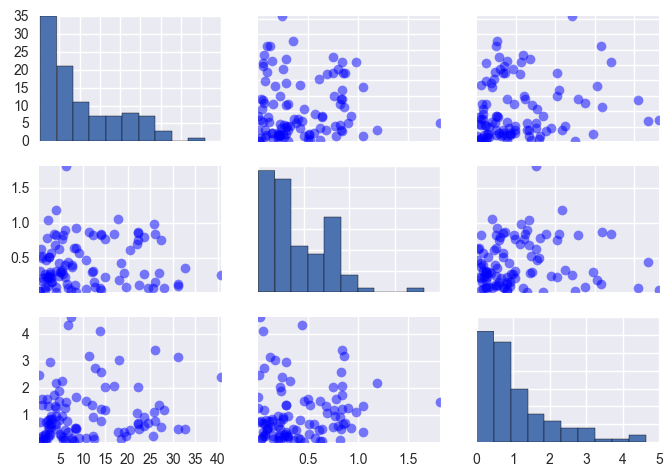

In [18]:
res = m.trace()

plt.figure()
print('Initial Distribution')
m.trace(plot=True,tol=0)

Middle Tolerance


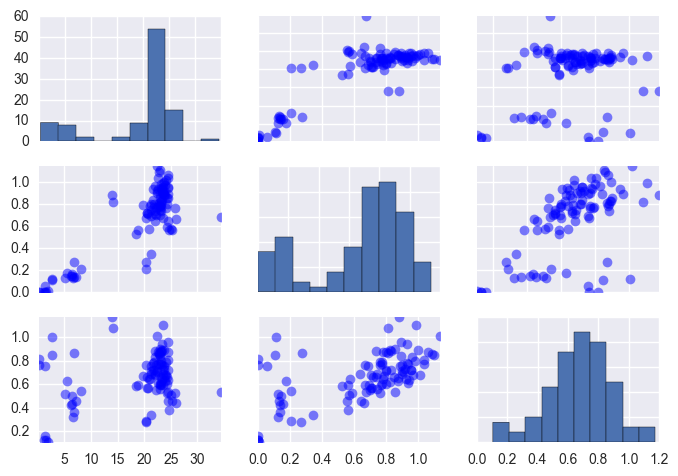

In [19]:
plt.figure()
print('Middle Tolerance')
m.trace(plot=True,tol=5)

Final Distribution


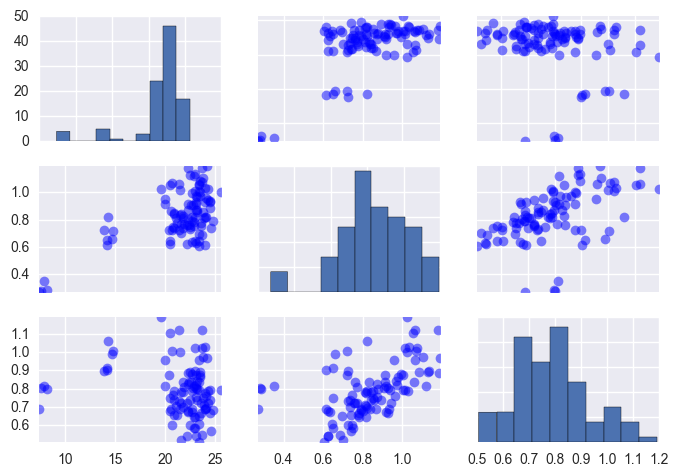

In [20]:
plt.figure()
print('Final Distribution')
m.trace(plot=True,tol=-1)

## Find point estimates of fit
Use the ```paramMAP()``` method to find the maximum a posteriori for each of the parameters.
```fitSummary()``` method also includes the 95% confidence intervals, based on the sampled posterior.

In [21]:
ps = np.round(m.paramMAP(),decimals=2)
print('MAP for infection rate is : {}, MAP for death rate is {} and MAP for heterogeneity is {}'.format(*ps))

res = m.fitSummary()

MAP for infection rate is : 21.55, MAP for death rate is 0.84 and MAP for heterogeneity is 0.79
param 0 : 22.7029896186 (7.99926587137,24.5287420372) 
param 1 : 0.826448837353 (0.317684634474,1.15625449511) 
param 2 : 0.784285034824 (0.541621246852,1.11281931268) 


As you can see we've not done a bad job at fitting. True parameters are 10,0.5 and 1.0 which all over-lap with the 95% confidence intervals. We may now save the results using the `save` method.

In [11]:
m.save('parasite_model_example')